# Limpieza e Integración de Datos de la NBA

Este notebook procesa y limpia los datos extraídos de la NBA, combinando la votación del MVP, estadísticas de jugadores y rendimiento de equipos en un único conjunto de datos unificado.

## Resumen del Proceso:
1. Limpiar datos de votación del MVP
2. Limpiar estadísticas de jugadores
3. Manejar normalización de nombres de jugadores y problemas de codificación
4. Fusionar traspasos de jugadores (jugadores que cambiaron de equipo a mitad de temporada)
5. Integrar estadísticas de equipos
6. Manejar valores faltantes y conversiones de tipos de datos
7. Visualizar insights clave

In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import unicodedata

## 1. Limpieza del Conjunto de Datos del MVP

Cargar y filtrar los datos de votación del MVP para mantener solo las columnas relevantes.

In [2]:
# Cargar datos de votación del MVP desde CSV
# Manejar errores de codificación reemplazando caracteres problemáticos
mvp = pd.read_csv('../web_scraping/mvps.csv', encoding='utf-8', encoding_errors='replace')
mvp

,Unnamed: 0,Rank,Player,Age,Tm,First,Pts Won,Pts Max,Share,G,...,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,Year
0,0,1,Michael Jordan,27,CHI,77,891,960,0.928,82,...,6.0,5.5,2.7,1.0,0.539,0.312,0.851,20.3,0.321,1991
1,1,2,Magic Johnson,31,LAL,10,497,960,0.518,79,...,7.0,12.5,1.3,0.2,0.477,0.320,0.906,15.4,0.251,1991
2,2,3,David Robinson,25,SAS,6,476,960,0.496,82,...,13.0,2.5,1.5,3.9,0.552,0.143,0.762,17.0,0.264,1991
3,3,4,Charles Barkley,27,PHI,2,222,960,0.231,67,...,10.1,4.2,1.6,0.5,0.570,0.284,0.722,13.4,0.258,1991
4,4,5,Karl Malone,27,UTA,0,142,960,0.148,82,...,11.8,3.3,1.1,1.0,0.527,0.286,0.770,15.5,0.225,1991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,4,5,Jalen Brunson,27,NYK,0,142,990,0.143,77,...,3.6,6.7,0.9,0.2,0.479,0.401,0.847,11.2,0.198,2024
504,5,6,Jayson Tatum,25,BOS,0,86,990,0.087,74,...,8.1,4.9,1.0,0.6,0.471,0.376,0.833,10.4,0.189,2024
505,6,7,Anthony Edwards,22,MIN,0,18,990,0.018,79,...,5.4,5.1,1.3,0.5,0.461,0.357,0.836,7.5,0.130,2024
506,7,8,Domantas Sabonis,27,SAC,0,3,990,0.003,82,...,13.7,8.2,0.9,0.6,0.594,0.379,0.704,12.6,0.206,2024


In [3]:
# Seleccionar solo las columnas relevantes para el análisis del MVP
# Mantenemos métricas de votación e identificación del jugador
mvp_cleaned = mvp[["Player", "Year", "Pts Won", "Pts Max", "Share"]]

In [4]:
# Mostrar datos limpios del MVP
mvp_cleaned

,Player,Year,Pts Won,Pts Max,Share
0,Michael Jordan,1991,891,960,0.928
1,Magic Johnson,1991,497,960,0.518
2,David Robinson,1991,476,960,0.496
3,Charles Barkley,1991,222,960,0.231
4,Karl Malone,1991,142,960,0.148
...,...,...,...,...,...
503,Jalen Brunson,2024,142,990,0.143
504,Jayson Tatum,2024,86,990,0.087
505,Anthony Edwards,2024,18,990,0.018
506,Domantas Sabonis,2024,3,990,0.003


## 2. Limpieza del Conjunto de Datos de Jugadores

Procesar estadísticas de jugadores y manejar casos especiales como traspasos a mitad de temporada.

In [5]:
# Cargar estadísticas de jugadores desde CSV
player = pd.read_csv('../web_scraping/players.csv', encoding='utf-8', encoding_errors='replace')
player

,Unnamed: 0,Rk,Player,Age,Team,Pos,G,GS,MP,FG,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,0,1,Michael Jordan,27,CHI,SG,82,82,37.0,12.1,...,1.4,4.6,6.0,5.5,2.7,1.0,2.5,2.8,31.5,1991
1,1,2,Karl Malone,27,UTA,PF,82,82,40.3,10.3,...,2.9,8.9,11.8,3.3,1.1,1.0,3.0,3.3,29.0,1991
2,2,3,Bernard King,34,WSB,SF,64,64,37.5,11.1,...,1.8,3.2,5.0,4.6,0.9,0.3,4.0,2.9,28.4,1991
3,3,4,Charles Barkley,27,PHI,SF,67,67,37.3,9.9,...,3.9,6.3,10.1,4.2,1.6,0.5,3.1,2.6,27.6,1991
4,4,5,Patrick Ewing,28,NYK,C,81,81,38.3,10.4,...,2.4,8.8,11.2,3.0,1.0,3.2,3.6,3.5,26.6,1991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20238,754,569,Ron Harper Jr.,23,TOR,PF,1,0,4.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2024
20239,755,570,Justin Jackson,28,MIN,SF,2,0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024
20240,756,571,Dmytro Skapintsev,25,NYK,C,2,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024
20241,757,572,Javonte Smart,24,PHI,PG,1,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2024


In [6]:
# Eliminar columnas innecesarias
# 'Unnamed: 0' es el índice de pandas, 'Rk' es el rango que no necesitamos
del player['Unnamed: 0']
del player['Rk']

In [7]:
# Eliminar asteriscos de los nombres de jugadores (indica estatus de Hall of Fame)
# No necesitamos este marcador para nuestro análisis
player["Player"] = player["Player"].str.replace("*", "", regex=False)

In [8]:
# Manejar jugadores que fueron traspasados a mitad de temporada
# Los jugadores traspasados durante la temporada tienen múltiples filas (una por equipo + total)
# Queremos mantener solo los totales de temporada y registrar su equipo final

def fuse_player(df):
    """
    Para jugadores con entradas de múltiples equipos (traspasados a mitad de temporada):
    - Mantener la fila con estadísticas totales (Equipo terminando en 'TM')
    - Reemplazar 'TM' con el último equipo del jugador de la temporada
    
    Para jugadores con entrada de un solo equipo:
    - Devolver tal cual
    """
    # Si solo hay una fila, el jugador no fue traspasado
    if df.shape[0] == 1:
        return df
    
    else:
        # Seleccionar la fila con totales de temporada (Equipo termina con "TM")
        row = df[df["Team"].str.endswith("TM")]
        
        # Obtener el último equipo en el que jugó el jugador (última fila del grupo)
        # Reemplazar el marcador "xTM" con el equipo real final
        row["Team"] = df.iloc[-1, :]["Team"]
        return row

# Aplicar la función para fusionar las estadísticas de jugadores traspasados
players_cleaned = player.groupby(["Player", "Year"]).apply(fuse_player).reset_index(drop=True)

/tmp/ipykernel_7418/2992011493.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  players_cleaned = player.groupby(["Player", "Year"]).apply(fuse_player).reset_index(drop=True)


In [9]:
# Eliminar filas de "League Average" que no son jugadores reales
players_cleaned = players_cleaned[players_cleaned["Player"] != "League Average"]

In [10]:
# Verificar: Comprobar un ejemplo de jugador traspasado (Greg Anderson en 1991)
# Ahora debería mostrar solo una fila con su equipo final
players_cleaned[players_cleaned["Player"] == "Greg Anderson"]

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
5748,Greg Anderson,26,DEN,PF,68,2,13.6,1.7,4.0,.430,...,1.4,3.3,4.7,0.2,0.5,0.7,1.2,2.1,4.3,1991
5749,Greg Anderson,27,DEN,PF,82,82,34.1,4.7,10.4,.456,...,4.1,7.4,11.5,1.0,1.1,0.8,2.5,3.2,11.5,1992
5750,Greg Anderson,29,DET,PF,77,47,21.1,2.6,4.8,.543,...,2.4,5.0,7.4,0.7,0.7,0.9,1.2,3.0,6.4,1994
5751,Greg Anderson,30,ATL,PF,51,0,12.2,1.1,2.0,.548,...,1.2,2.5,3.7,0.3,0.5,0.6,0.6,2.0,2.9,1995
5752,Greg Anderson,31,SAS,PF,46,7,7.5,0.5,1.0,.511,...,0.6,1.5,2.2,0.2,0.2,0.5,0.5,1.4,1.2,1996
5753,Greg Anderson,32,SAS,C,82,48,20.2,1.6,3.2,.496,...,1.9,3.5,5.5,0.4,0.8,0.8,0.9,2.7,3.9,1997
5754,Greg Anderson,33,ATL,C,50,0,8.0,0.7,1.6,.444,...,0.8,1.6,2.4,0.3,0.4,0.2,0.3,1.7,1.8,1998


In [11]:
# Mostrar estadísticas de jugadores limpias
players_cleaned

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Year
0,A.C. Green,27,LAL,PF,82,21,26.4,3.1,6.6,.476,...,2.5,3.8,6.3,0.9,0.7,0.3,1.2,1.4,9.1,1991
1,A.C. Green,28,LAL,PF,82,53,35.4,4.7,9.8,.476,...,3.7,5.6,9.3,1.4,1.1,0.4,1.4,1.7,13.6,1992
2,A.C. Green,29,LAL,PF,82,55,34.4,4.6,8.6,.537,...,3.5,5.2,8.7,1.4,1.1,0.5,1.4,1.8,12.8,1993
3,A.C. Green,30,PHO,PF,82,55,34.5,5.7,11.3,.502,...,3.4,5.8,9.2,1.7,0.9,0.5,1.2,1.7,14.7,1994
4,A.C. Green,31,PHO,SF,82,52,32.8,3.8,7.5,.504,...,2.4,5.8,8.2,1.5,0.7,0.4,1.4,1.8,11.2,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15837,Željko Rebrača,29,DET,C,74,4,15.9,2.6,5.1,.505,...,1.1,2.8,3.9,0.5,0.4,1.0,1.1,2.6,6.9,2002
15838,Željko Rebrača,30,DET,C,30,12,16.3,2.7,4.8,.552,...,0.9,2.2,3.1,0.3,0.2,0.6,1.0,2.6,6.6,2003
15839,Željko Rebrača,31,ATL,C,24,2,11.4,1.4,3.2,.442,...,1.0,1.5,2.4,0.3,0.2,0.5,0.7,2.2,3.8,2004
15840,Željko Rebrača,32,LAC,C,58,2,16.0,2.3,4.0,.568,...,0.8,2.3,3.2,0.4,0.2,0.7,0.8,2.2,5.8,2005


In [ ]:
# Normalizar nombres de jugadores para manejar problemas de codificación y caracteres especiales
# Esto es crítico para fusionar correctamente los conjuntos de datos

def normalize_name(name):
    """
    Normalizar nombres de jugadores mediante:
    1. Arreglar corrupción de codificación común (ej: Ä, Ã³, Ã)
    2. Eliminar acentos y diacríticos
    3. Convertir a caracteres solo ASCII
    
    Ejemplos:
    - "StojakoviÄ" -> "Stojakovic"
    - "GinÃ³bili" -> "Ginobili"
    - "DragiÄ" -> "Dragic"
    """
    name_str = str(name)
    
    # Arreglar caracteres corruptos comunes de problemas de codificación
    replacements = {
        'Ä': 'c',   # Caracteres Čeština
        'Ã³': 'o',  
        'Ã': 'i',
        '¡': 'c',
        'Ä': 'c'
    }
    
    for old, new in replacements.items():
        name_str = name_str.replace(old, new)
    
    # Descomponer caracteres con acentos (ej: é -> e + acento)
    nfkd_form = unicodedata.normalize('NFKD', name_str)
    
    # Mantener solo caracteres ASCII (elimina las marcas de acento)
    only_ascii = "".join([c for c in nfkd_form if not unicodedata.combining(c)])
    
    # Limpieza adicional: eliminar cualquier carácter no-ASCII restante
    final_name = "".join([c if ord(c) < 128 else '' for c in only_ascii])
    
    return final_name

## 3. Fusión de Conjuntos de Datos de Jugadores y MVP

Combinar estadísticas de jugadores con datos de votación del MVP usando nombres normalizados.

In [13]:
# Normalizar nombres de jugadores en ambos conjuntos de datos para fusión consistente
players_cleaned["Player"] = players_cleaned["Player"].apply(normalize_name)
mvp_cleaned["Player"] = mvp_cleaned["Player"].apply(normalize_name)

# Fusionar conjuntos de datos usando outer join para mantener todos los jugadores
# Outer join asegura que mantengamos:
# - Todos los candidatos al MVP (de mvp_cleaned)
# - Todos los jugadores (de players_cleaned)
# - Valores faltantes llenados con NaN donde los datos no existen
combine_stats = players_cleaned.merge(mvp_cleaned, how="outer", on=["Player", "Year"])

/tmp/ipykernel_7418/1094746939.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mvp_cleaned["Player"] = mvp_cleaned["Player"].apply(normalize_name)


In [14]:
# Vista previa del conjunto de datos fusionado
combine_stats.head()

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,AST,STL,BLK,TOV,PF,PTS,Year,Pts Won,Pts Max,Share
0,A.C. Green,27,LAL,PF,82,21,26.4,3.1,6.6,.476,...,0.9,0.7,0.3,1.2,1.4,9.1,1991,NaN,NaN,NaN
1,A.C. Green,28,LAL,PF,82,53,35.4,4.7,9.8,.476,...,1.4,1.1,0.4,1.4,1.7,13.6,1992,NaN,NaN,NaN
2,A.C. Green,29,LAL,PF,82,55,34.4,4.6,8.6,.537,...,1.4,1.1,0.5,1.4,1.8,12.8,1993,NaN,NaN,NaN
3,A.C. Green,30,PHO,PF,82,55,34.5,5.7,11.3,.502,...,1.7,0.9,0.5,1.2,1.7,14.7,1994,NaN,NaN,NaN
4,A.C. Green,31,PHO,SF,82,52,32.8,3.8,7.5,.504,...,1.5,0.7,0.4,1.4,1.8,11.2,1995,NaN,NaN,NaN


In [ ]:
# Llenar valores NaN con 0 para columnas de votación del MVP
# Los jugadores que no recibieron votos para MVP tendrán NaN, que reemplazamos con 0
combine_stats[["Pts Won", "Pts Max", "Share"]] = combine_stats[["Pts Won", "Pts Max", "Share"]].fillna(0)

In [15]:
# Mostrar estadísticas combinadas
combine_stats

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,AST,STL,BLK,TOV,PF,PTS,Year,Pts Won,Pts Max,Share
0,A.C. Green,27,LAL,PF,82,21,26.4,3.1,6.6,.476,...,0.9,0.7,0.3,1.2,1.4,9.1,1991,NaN,NaN,NaN
1,A.C. Green,28,LAL,PF,82,53,35.4,4.7,9.8,.476,...,1.4,1.1,0.4,1.4,1.7,13.6,1992,NaN,NaN,NaN
2,A.C. Green,29,LAL,PF,82,55,34.4,4.6,8.6,.537,...,1.4,1.1,0.5,1.4,1.8,12.8,1993,NaN,NaN,NaN
3,A.C. Green,30,PHO,PF,82,55,34.5,5.7,11.3,.502,...,1.7,0.9,0.5,1.2,1.7,14.7,1994,NaN,NaN,NaN
4,A.C. Green,31,PHO,SF,82,52,32.8,3.8,7.5,.504,...,1.5,0.7,0.4,1.4,1.8,11.2,1995,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15803,Zydrunas Ilgauskas,33,CLE,C,65,65,27.2,5.3,11.1,.472,...,1.0,0.4,1.3,1.4,2.8,12.9,2009,NaN,NaN,NaN
15804,Zydrunas Ilgauskas,34,CLE,C,64,6,20.9,3.0,6.8,.443,...,0.8,0.2,0.8,1.0,2.9,7.4,2010,NaN,NaN,NaN
15805,Zydrunas Ilgauskas,35,MIA,C,72,51,15.9,2.3,4.4,.508,...,0.4,0.3,0.8,0.7,2.6,5.0,2011,NaN,NaN,NaN
15806,Zylan Cheatham,24,NOP,PF,4,0,12.8,1.5,2.3,.667,...,0.8,0.3,0.3,1.0,2.5,3.0,2020,NaN,NaN,NaN


## 4. Integración de Estadísticas de Equipos

Añadir datos de rendimiento de equipos para proporcionar contexto a los logros de los jugadores.

In [16]:
# Cargar estadísticas de equipos
teams = pd.read_csv('../web_scraping/teams.csv', encoding='utf-8', encoding_errors='replace')
del teams['Unnamed: 0']

In [17]:
# Vista previa de datos de equipos
teams.head(50)

,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team
0,56,26,.683,—,111.5,105.7,5.22,1991,Boston Celtics*
1,44,38,.537,12.0,105.4,105.6,-0.39,1991,Philadelphia 76ers*
2,39,43,.476,17.0,103.1,103.3,-0.43,1991,New York Knicks*
3,30,52,.366,26.0,101.4,106.4,-4.84,1991,Washington Bullets
4,26,56,.317,30.0,102.9,107.5,-4.53,1991,New Jersey Nets
5,24,58,.293,32.0,101.8,107.8,-5.91,1991,Miami Heat
6,Central Division,Central Division,Central Division,Central Division,Central Division,Central Division,Central Division,1991,Central Division
7,61,21,.744,—,110.0,101.0,8.57,1991,Chicago Bulls*
8,50,32,.610,11.0,100.1,96.8,3.08,1991,Detroit Pistons*
9,48,34,.585,13.0,106.4,104.0,2.33,1991,Milwaukee Bucks*


In [18]:
# Eliminar filas de encabezado de división que fueron extraídas incorrectamente
# Estas contienen la palabra "Division" en la columna "W" (Victorias)
teams = teams[~teams["W"].str.contains("Division")]

In [19]:
# Eliminar asteriscos de los nombres de equipos
teams["Team"] = teams["Team"].str.replace("*", "", regex=False)

In [20]:
# Verificar limpieza
teams.head(50)

,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team
0,56,26,.683,—,111.5,105.7,5.22,1991,Boston Celtics
1,44,38,.537,12.0,105.4,105.6,-0.39,1991,Philadelphia 76ers
2,39,43,.476,17.0,103.1,103.3,-0.43,1991,New York Knicks
3,30,52,.366,26.0,101.4,106.4,-4.84,1991,Washington Bullets
4,26,56,.317,30.0,102.9,107.5,-4.53,1991,New Jersey Nets
5,24,58,.293,32.0,101.8,107.8,-5.91,1991,Miami Heat
7,61,21,.744,—,110.0,101.0,8.57,1991,Chicago Bulls
8,50,32,.610,11.0,100.1,96.8,3.08,1991,Detroit Pistons
9,48,34,.585,13.0,106.4,104.0,2.33,1991,Milwaukee Bucks
10,43,39,.524,18.0,109.8,109.0,0.72,1991,Atlanta Hawks


### Estandarización de Nombres de Equipos

**Problema:** Los nombres de equipos en el conjunto de datos de equipos son nombres completos (ej: "Los Angeles Lakers"), mientras que los datos de jugadores usan abreviaturas (ej: "LAL").

**Solución:** Mapear abreviaturas a nombres completos usando un archivo de búsqueda.

In [21]:
# Mostrar nombres únicos de equipos en conjunto de datos de equipos (nombres completos)
teams["Team"].unique()

array(['Boston Celtics', 'Philadelphia 76ers', 'New York Knicks',
       'Washington Bullets', 'New Jersey Nets', 'Miami Heat',
       'Chicago Bulls', 'Detroit Pistons', 'Milwaukee Bucks',
       'Atlanta Hawks', 'Indiana Pacers', 'Cleveland Cavaliers',
       'Charlotte Hornets', 'San Antonio Spurs', 'Utah Jazz',
       'Houston Rockets', 'Orlando Magic', 'Minnesota Timberwolves',
       'Dallas Mavericks', 'Denver Nuggets', 'Portland Trail Blazers',
       'Los Angeles Lakers', 'Phoenix Suns', 'Golden State Warriors',
       'Seattle SuperSonics', 'Los Angeles Clippers', 'Sacramento Kings',
       'Toronto Raptors', 'Vancouver Grizzlies', 'Washington Wizards',
       'Memphis Grizzlies', 'New Orleans Hornets', 'Charlotte Bobcats',
       'New Orleans/Oklahoma City Hornets', 'Oklahoma City Thunder',
       'Brooklyn Nets', 'New Orleans Pelicans'], dtype=object)

In [22]:
# Mostrar abreviaturas únicas de equipos en estadísticas combinadas (abreviado)
combine_stats["Team"].unique()

array(['LAL', 'PHO', 'DAL', 'MIA', 'CLE', 'WSB', 'MIL', 'CHI', 'GSW',
       'IND', 'WAS', 'MIN', 'BOS', 'ATL', 'HOU', 'DEN', 'ORL', 'NOH',
       'TOR', 'SAC', 'CHO', 'PHI', 'POR', 'DET', 'OKC', 'UTA', 'VAN',
       'SEA', 'NJN', 'NOK', 'LAC', 'CHA', 'MEM', 'NYK', 'NOP', 'BRK',
       'SAS', 'CHH'], dtype=object)

In [23]:
# Cargar mapeo de nombres de equipos desde archivo de apodos
# Formato: abreviatura,nombre_completo
nicknames_teams = {}

with open("nicknames.txt", encoding='utf-8') as f:
    lines = f.readlines()
    for line in lines[1:]:  # Saltar línea de encabezado
        # Eliminar nueva línea y dividir por coma
        abbr, name = line.replace("\n", "").split(",")
        nicknames_teams[abbr] = name
        
nicknames_teams

{'ATL': 'Atlanta Hawks',
 'BRK': 'Brooklyn Nets',
 'BKN': 'Brooklyn Nets',
 'BOS': 'Boston Celtics',
 'CHA': 'Charlotte Bobcats',
 'CHH': 'Charlotte Hornets',
 'CHO': 'Charlotte Hornets',
 'CHI': 'Chicago Bulls',
 'CLE': 'Cleveland Cavaliers',
 'DAL': 'Dallas Mavericks',
 'DEN': 'Denver Nuggets',
 'DET': 'Detroit Pistons',
 'GSW': 'Golden State Warriors',
 'HOU': 'Houston Rockets',
 'IND': 'Indiana Pacers',
 'LAC': 'Los Angeles Clippers',
 'LAL': 'Los Angeles Lakers',
 'MEM': 'Memphis Grizzlies',
 'MIA': 'Miami Heat',
 'MIL': 'Milwaukee Bucks',
 'MIN': 'Minnesota Timberwolves',
 'NJN': 'New Jersey Nets',
 'NOH': 'New Orleans Hornets',
 'NOP': 'New Orleans Pelicans',
 'NOK': 'New Orleans/Oklahoma City Hornets',
 'NYK': 'New York Knicks',
 'OKC': 'Oklahoma City Thunder',
 'ORL': 'Orlando Magic',
 'PHI': 'Philadelphia 76ers',
 'PHX': 'Phoenix Suns',
 'PHO': 'Phoenix Suns',
 'POR': 'Portland Trail Blazers',
 'SEA': 'Seattle SuperSonics',
 'SAC': 'Sacramento Kings',
 'SAS': 'San Antonio Spu

In [24]:
# Convertir abreviaturas de equipos a nombres completos usando el mapeo
combine_stats["Team"] = combine_stats["Team"].map(nicknames_teams)
combine_stats

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,AST,STL,BLK,TOV,PF,PTS,Year,Pts Won,Pts Max,Share
0,A.C. Green,27,Los Angeles Lakers,PF,82,21,26.4,3.1,6.6,.476,...,0.9,0.7,0.3,1.2,1.4,9.1,1991,NaN,NaN,NaN
1,A.C. Green,28,Los Angeles Lakers,PF,82,53,35.4,4.7,9.8,.476,...,1.4,1.1,0.4,1.4,1.7,13.6,1992,NaN,NaN,NaN
2,A.C. Green,29,Los Angeles Lakers,PF,82,55,34.4,4.6,8.6,.537,...,1.4,1.1,0.5,1.4,1.8,12.8,1993,NaN,NaN,NaN
3,A.C. Green,30,Phoenix Suns,PF,82,55,34.5,5.7,11.3,.502,...,1.7,0.9,0.5,1.2,1.7,14.7,1994,NaN,NaN,NaN
4,A.C. Green,31,Phoenix Suns,SF,82,52,32.8,3.8,7.5,.504,...,1.5,0.7,0.4,1.4,1.8,11.2,1995,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15803,Zydrunas Ilgauskas,33,Cleveland Cavaliers,C,65,65,27.2,5.3,11.1,.472,...,1.0,0.4,1.3,1.4,2.8,12.9,2009,NaN,NaN,NaN
15804,Zydrunas Ilgauskas,34,Cleveland Cavaliers,C,64,6,20.9,3.0,6.8,.443,...,0.8,0.2,0.8,1.0,2.9,7.4,2010,NaN,NaN,NaN
15805,Zydrunas Ilgauskas,35,Miami Heat,C,72,51,15.9,2.3,4.4,.508,...,0.4,0.3,0.8,0.7,2.6,5.0,2011,NaN,NaN,NaN
15806,Zylan Cheatham,24,New Orleans Pelicans,PF,4,0,12.8,1.5,2.3,.667,...,0.8,0.3,0.3,1.0,2.5,3.0,2020,NaN,NaN,NaN


In [25]:
# Mostrar estadísticas de equipos
teams

,W,L,W/L%,GB,PS/G,PA/G,SRS,Year,Team
0,56,26,.683,—,111.5,105.7,5.22,1991,Boston Celtics
1,44,38,.537,12.0,105.4,105.6,-0.39,1991,Philadelphia 76ers
2,39,43,.476,17.0,103.1,103.3,-0.43,1991,New York Knicks
3,30,52,.366,26.0,101.4,106.4,-4.84,1991,Washington Bullets
4,26,56,.317,30.0,102.9,107.5,-4.53,1991,New Jersey Nets
...,...,...,...,...,...,...,...,...,...
1133,50,32,.610,—,117.9,115.6,2.30,2024,Dallas Mavericks
1134,49,33,.598,1.0,115.1,110.7,4.46,2024,New Orleans Pelicans
1135,41,41,.500,9.0,114.3,113.2,1.24,2024,Houston Rockets
1136,27,55,.329,23.0,105.8,112.8,-6.57,2024,Memphis Grizzlies


In [26]:
# Fusionar estadísticas de jugador+MVP con estadísticas de equipos
# Outer join preserva todos los datos, llenando valores faltantes con NaN
combined_stats_master = combine_stats.merge(teams, how="outer", on=["Team", "Year"])

In [27]:
# Mostrar el conjunto de datos maestro
combined_stats_master

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,Pts Won,Pts Max,Share,W,L,W/L%,GB,PS/G,PA/G,SRS
0,Doc Rivers,29,Atlanta Hawks,PG,79,79,32.7,5.6,12.9,.435,...,NaN,NaN,NaN,43,39,.524,18.0,109.8,109.0,0.72
1,Dominique Wilkins,31,Atlanta Hawks,SF,81,81,38.0,9.5,20.2,.470,...,29.0,960.0,0.03,43,39,.524,18.0,109.8,109.0,0.72
2,Duane Ferrell,25,Atlanta Hawks,SF,78,2,14.9,2.2,4.6,.489,...,NaN,NaN,NaN,43,39,.524,18.0,109.8,109.0,0.72
3,Gary Leonard,23,Atlanta Hawks,C,4,0,2.3,0.0,0.0,NaN,...,NaN,NaN,NaN,43,39,.524,18.0,109.8,109.0,0.72
4,John Battle,28,Atlanta Hawks,SG,79,2,23.6,5.0,10.9,.461,...,NaN,NaN,NaN,43,39,.524,18.0,109.8,109.0,0.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15803,Marvin Bagley III,24,Washington Wizards,C,50,25,21.1,4.8,8.2,.586,...,NaN,NaN,NaN,15,67,.183,32.0,113.7,123.0,-9.29
15804,Patrick Baldwin Jr.,21,Washington Wizards,SF,38,7,13.0,1.6,4.1,.381,...,NaN,NaN,NaN,15,67,.183,32.0,113.7,123.0,-9.29
15805,Richaun Holmes,30,Washington Wizards,C,40,10,13.9,2.1,3.7,.558,...,NaN,NaN,NaN,15,67,.183,32.0,113.7,123.0,-9.29
15806,Tristan Vukcevic,20,Washington Wizards,C,10,4,15.3,2.9,6.7,.433,...,NaN,NaN,NaN,15,67,.183,32.0,113.7,123.0,-9.29


In [28]:
# Verificar tipos de datos actuales
combined_stats_master.dtypes

Player      object
Age         object
Team        object
Pos         object
G           object
GS          object
MP          object
FG          object
FGA         object
FG%         object
3P          object
3PA         object
3P%         object
2P          object
2PA         object
2P%         object
eFG%        object
FT          object
FTA         object
FT%         object
ORB         object
DRB         object
TRB         object
AST         object
STL         object
BLK         object
TOV         object
PF          object
PTS         object
Year         int64
Pts Won    float64
Pts Max    float64
Share      float64
W           object
L           object
W/L%        object
GB          object
PS/G        object
PA/G        object
SRS         object
dtype: object

## 5. Conversiones de Tipos de Datos y Manejo de Valores Faltantes

In [29]:
# Convertir columnas numéricas a tipos de datos apropiados
# pd.to_numeric convierte strings a números donde sea posible, ignora columnas no-numéricas
combined_stats_master = combined_stats_master.apply(pd.to_numeric, errors="ignore")

/tmp/ipykernel_7418/1650269407.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  combined_stats_master = combined_stats_master.apply(pd.to_numeric, errors="ignore")


In [30]:
# Verificar tipos de datos después de la conversión
combined_stats_master.dtypes

Player      object
Age          int64
Team        object
Pos         object
G            int64
GS           int64
MP         float64
FG         float64
FGA        float64
FG%        float64
3P         float64
3PA        float64
3P%        float64
2P         float64
2PA        float64
2P%        float64
eFG%       float64
FT         float64
FTA        float64
FT%        float64
ORB        float64
DRB        float64
TRB        float64
AST        float64
STL        float64
BLK        float64
TOV        float64
PF         float64
PTS        float64
Year         int64
Pts Won    float64
Pts Max    float64
Share      float64
W            int64
L            int64
W/L%       float64
GB          object
PS/G       float64
PA/G       float64
SRS        float64
dtype: object

In [31]:
# Verificar valores únicos en columna "GB" (Games Behind - Juegos Detrás)
# Esta columna no se convirtió correctamente debido al carácter "—" para equipos en 1er lugar
combined_stats_master["GB"].unique()

array(['18.0', '29.0', '14.0', '—', '10.0', '26.0', '13.0', '12.0', '2.0',
       '28.0', '27.0', '17.0', '15.0', '33.0', '46.0', '6.0', '22.0',
       '16.0', '20.0', '21.0', '3.0', '11.0', '25.0', '19.0', '5.0',
       '23.0', '12.5', '9.0', '8.0', '4.0', '35.0', '31.0', '1.0', '7.0',
       '32.0', '41.0', '24.0', '39.0', '45.0', '36.0', '37.0', '38.0',
       '4.5', '30.0', '43.0', '25.5', '44.0', '40.0', '42.0', '2.5',
       '51.0', '34.0', '20.5', '32.5', '48.0', '52.0', '3.5', '56.0',
       '10.5', '47.0', '11.5', '22.5', '1.5', '50.0', '21.5', '18.5'],
      dtype=object)

In [32]:
# Reemplazar el guión largo "—" con "0" para equipos en primer lugar
combined_stats_master["GB"] = combined_stats_master["GB"].replace("—", "0")
combined_stats_master["GB"].unique()

array(['18.0', '29.0', '14.0', '0', '10.0', '26.0', '13.0', '12.0', '2.0',
       '28.0', '27.0', '17.0', '15.0', '33.0', '46.0', '6.0', '22.0',
       '16.0', '20.0', '21.0', '3.0', '11.0', '25.0', '19.0', '5.0',
       '23.0', '12.5', '9.0', '8.0', '4.0', '35.0', '31.0', '1.0', '7.0',
       '32.0', '41.0', '24.0', '39.0', '45.0', '36.0', '37.0', '38.0',
       '4.5', '30.0', '43.0', '25.5', '44.0', '40.0', '42.0', '2.5',
       '51.0', '34.0', '20.5', '32.5', '48.0', '52.0', '3.5', '56.0',
       '10.5', '47.0', '11.5', '22.5', '1.5', '50.0', '21.5', '18.5'],
      dtype=object)

In [33]:
# Convertir columna GB a tipo numérico
combined_stats_master["GB"] = pd.to_numeric(combined_stats_master["GB"])
combined_stats_master.dtypes

Player      object
Age          int64
Team        object
Pos         object
G            int64
GS           int64
MP         float64
FG         float64
FGA        float64
FG%        float64
3P         float64
3PA        float64
3P%        float64
2P         float64
2PA        float64
2P%        float64
eFG%       float64
FT         float64
FTA        float64
FT%        float64
ORB        float64
DRB        float64
TRB        float64
AST        float64
STL        float64
BLK        float64
TOV        float64
PF         float64
PTS        float64
Year         int64
Pts Won    float64
Pts Max    float64
Share      float64
W            int64
L            int64
W/L%       float64
GB         float64
PS/G       float64
PA/G       float64
SRS        float64
dtype: object

In [34]:
# Contar valores nulos en cada columna
pd.isnull(combined_stats_master).sum()

Player         0
Age            0
Team           0
Pos            0
G              0
GS             0
MP             0
FG             0
FGA            0
FG%           65
3P             0
3PA            0
3P%         2134
2P             0
2PA            0
2P%          110
eFG%          65
FT             0
FTA            0
FT%          580
ORB            0
DRB            0
TRB            0
AST            0
STL            0
BLK            0
TOV            0
PF             0
PTS            0
Year           0
Pts Won    15300
Pts Max    15300
Share      15300
W              0
L              0
W/L%           0
GB             0
PS/G           0
PA/G           0
SRS            0
dtype: int64

In [35]:
# Investigar valores NaN en 3P% (porcentaje de triples)
# Estos ocurren cuando un jugador intentó 0 triples (división por cero)
combined_stats_master[pd.isnull(combined_stats_master["3P%"])][["Player", "3P", "3P%"]]

,Player,3P,3P%
3,Gary Leonard,0.0,NaN
17,Gary Leonard,0.0,NaN
18,Jeff Sanders,0.0,NaN
34,Jeff Sanders,0.0,NaN
39,Randy Breuer,0.0,NaN
...,...,...,...
15756,Jaime Echenique,0.0,NaN
15768,Vernon Carey Jr.,0.0,NaN
15772,Daniel Gafford,0.0,NaN
15788,Vernon Carey Jr.,0.0,NaN


In [36]:
# Llenar todos los valores NaN restantes con 0
# Esto es apropiado para nuestro caso de uso (porcentajes de tiro con 0 intentos, estadísticas faltantes)
combined_stats_master = combined_stats_master.fillna(0)
combined_stats_master

,Player,Age,Team,Pos,G,GS,MP,FG,FGA,FG%,...,Pts Won,Pts Max,Share,W,L,W/L%,GB,PS/G,PA/G,SRS
0,Doc Rivers,29,Atlanta Hawks,PG,79,79,32.7,5.6,12.9,0.435,...,0.0,0.0,0.00,43,39,0.524,18.0,109.8,109.0,0.72
1,Dominique Wilkins,31,Atlanta Hawks,SF,81,81,38.0,9.5,20.2,0.470,...,29.0,960.0,0.03,43,39,0.524,18.0,109.8,109.0,0.72
2,Duane Ferrell,25,Atlanta Hawks,SF,78,2,14.9,2.2,4.6,0.489,...,0.0,0.0,0.00,43,39,0.524,18.0,109.8,109.0,0.72
3,Gary Leonard,23,Atlanta Hawks,C,4,0,2.3,0.0,0.0,0.000,...,0.0,0.0,0.00,43,39,0.524,18.0,109.8,109.0,0.72
4,John Battle,28,Atlanta Hawks,SG,79,2,23.6,5.0,10.9,0.461,...,0.0,0.0,0.00,43,39,0.524,18.0,109.8,109.0,0.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15803,Marvin Bagley III,24,Washington Wizards,C,50,25,21.1,4.8,8.2,0.586,...,0.0,0.0,0.00,15,67,0.183,32.0,113.7,123.0,-9.29
15804,Patrick Baldwin Jr.,21,Washington Wizards,SF,38,7,13.0,1.6,4.1,0.381,...,0.0,0.0,0.00,15,67,0.183,32.0,113.7,123.0,-9.29
15805,Richaun Holmes,30,Washington Wizards,C,40,10,13.9,2.1,3.7,0.558,...,0.0,0.0,0.00,15,67,0.183,32.0,113.7,123.0,-9.29
15806,Tristan Vukcevic,20,Washington Wizards,C,10,4,15.3,2.9,6.7,0.433,...,0.0,0.0,0.00,15,67,0.183,32.0,113.7,123.0,-9.29


In [37]:
# Exportar el conjunto de datos limpio final a CSV
combined_stats_master.to_csv("combined_stats_master.csv")

## 6. Visualización de Datos y Análisis Exploratorio

Visualizaciones rápidas para entender patrones en los datos.

<Axes: title={'center': 'Top 10 Actuaciones de Anotación en Una Temporada (Mín. 70 Partidos)'}, xlabel='Player'>

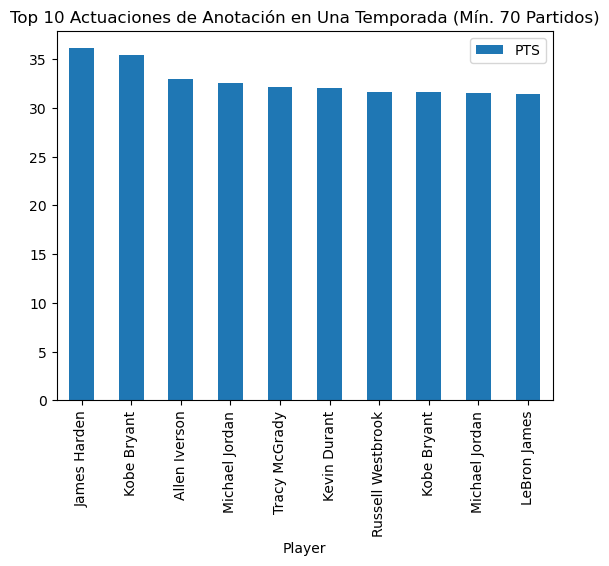

In [ ]:
highest_score = combined_stats_master[combined_stats_master["G"] > 70].sort_values(by="PTS", ascending=False).head(10)
highest_score.plot.bar(x="Player", y="PTS", title="Top 10 Actuaciones de Anotación en Una Temporada (Mín. 70 Partidos)")

/tmp/ipykernel_6097/2903415991.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hightest_score_per_year = combined_stats_master.groupby("Year").apply(lambda x: x.sort_values("PTS", ascending=False).head(1))


<Axes: title={'center': 'Jugador con más puntos por año'}, xlabel='Year'>

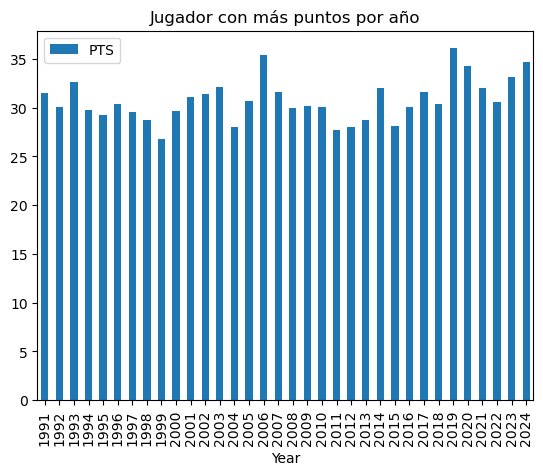

In [ ]:
highest_score_per_year = combined_stats_master.groupby("Year").apply(lambda x: x.sort_values("PTS", ascending=False).head(1))
highest_score_per_year.plot.bar(x="Year", y="PTS", title="Máximo Anotador Por Temporada")

<Axes: title={'center': 'Correlación de estadísticas con el Share de MVP'}>

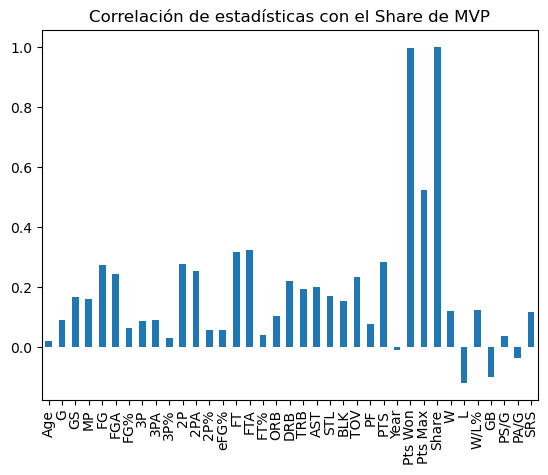

In [ ]:
# Calcular correlación entre todas las características numéricas y Share del MVP
# Esto muestra qué estadísticas son más predictivas de la votación del MVP
corr = combined_stats_master.corr(numeric_only=True)["Share"]
corr.plot.bar(title="Correlación de Estadísticas con Share de Votación del MVP")